In [9]:
# Task 1

from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import json
import time

# Initialize the driver
browser = webdriver.Chrome()

# Target URL
url = 'https://www.opentable.com/r/industry-kitchen-new-york?corrid=8378d68a-8db0-4407-b1c0-81768e053596&avt=eyJ2IjoyLCJtIjoxLCJwIjowLCJzIjowLCJuIjowfQ&p=2&sd=2024-12-01T19%3A00%3A00'
browser.get(url)

# Wait for the restaurant name and extract it
WebDriverWait(browser, 10).until(EC.presence_of_element_located((By.TAG_NAME, "h1")))
restaurant = browser.find_element(By.TAG_NAME, "h1").text.strip()

# List to store review data
collected_reviews = []
current_page = 1
total_pages = 90  # Limit the scraping to 2 pages

# Start scraping reviews
while current_page <= total_pages:
    # Wait until reviews are loaded
    WebDriverWait(browser, 10).until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "li[data-test='reviews-list-item']")))

    # Get the current page source and parse it
    html = browser.page_source
    parsed_html = BeautifulSoup(html, "html.parser")

    # Extract review elements
    review_items = parsed_html.find_all("li", {"data-test": "reviews-list-item"})

    for item in review_items:
        # Extract review details with appropriate checks
        name_tag = item.find("p", class_="_1p30XHjz2rI-")
        location_tag = item.find("p", class_="POyqzNMT21k-")
        rating_tag = item.find("div", class_="yEKDnyk-7-g-")
        date_tag = item.find("p", class_="iLkEeQbexGs-")
        text_tag = item.find("span", class_="l9bbXUdC9v0-", style=lambda val: val and "line-height" in val)

        # Store the extracted details in a dictionary
        review_data = {
            "Reviewer_Name": name_tag.text.strip() if name_tag else None,
            "Reviewer_Location": location_tag.text.strip() if location_tag else None,
            "Review_Date": date_tag.text.strip() if date_tag else None,
            "Rating": len(rating_tag.find_all("i", {"data-testid": "star-full"})) if rating_tag else None,
            "Review": text_tag.text.strip() if text_tag else None
        }

        collected_reviews.append(review_data)

    print(f"Page {current_page}: Collected {len(review_items)} reviews.")
    
    # Check if we've reached the max number of pages
    if current_page >= total_pages:
        print(f"Reached the maximum page limit of {total_pages}, stopping scraping.")
        break  # Stop scraping after max_pages

    # Attempt to click the 'Next' button
    try:
        # Re-locate the 'Next' button each time
        next_page_button = WebDriverWait(browser, 10).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, "div[data-test='pagination-next']"))
        )

        if next_page_button.is_enabled():
            next_page_button.click()
            current_page += 1
            print(f"Moving to page {current_page}")
            
            # Give some time for the new page to load
            time.sleep(3)
        else:
            print("Next page button is disabled, ending scraping.")
            break
    except Exception as e:
        print(f"Error occurred while clicking 'Next': {e}")
        break


# Prepare the final data
output = {
    "Restaurant": restaurant,
    "Reviews": collected_reviews
}

# Save to JSON
with open("restaurant_reviews.json", "w", encoding="utf-8") as f:
    json.dump(output, f, indent=4)

print("Data successfully saved to 'restaurant_reviews.json'.")

# Close the browser
browser.quit()


Page 1: Collected 10 reviews.
Moving to page 2
Page 2: Collected 10 reviews.
Moving to page 3
Page 3: Collected 10 reviews.
Moving to page 4
Page 4: Collected 10 reviews.
Moving to page 5
Page 5: Collected 10 reviews.
Moving to page 6
Page 6: Collected 10 reviews.
Moving to page 7
Page 7: Collected 10 reviews.
Moving to page 8
Page 8: Collected 10 reviews.
Moving to page 9
Page 9: Collected 10 reviews.
Moving to page 10
Page 10: Collected 10 reviews.
Moving to page 11
Page 11: Collected 10 reviews.
Moving to page 12
Page 12: Collected 10 reviews.
Moving to page 13
Page 13: Collected 10 reviews.
Moving to page 14
Page 14: Collected 10 reviews.
Moving to page 15
Page 15: Collected 10 reviews.
Moving to page 16
Page 16: Collected 10 reviews.
Moving to page 17
Page 17: Collected 10 reviews.
Moving to page 18
Page 18: Collected 10 reviews.
Moving to page 19
Page 19: Collected 10 reviews.
Moving to page 20
Page 20: Collected 10 reviews.
Moving to page 21
Page 21: Collected 10 reviews.
Moving

In [10]:
# Task 2

from groq import Groq
import os
import json
import re

# Set the API Key
os.environ['GROQ_API_KEY'] = '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'

# Initialize the Groq client
client = Groq(api_key=os.environ.get("GROQ_API_KEY"))

def ask(message, sys_message="You are a helpful agent.", model="llama3-8b-8192"):
    messages = [
        {"role": "system", "content": sys_message},
        {"role": "user", "content": message}
    ]
    response = client.chat.completions.create(model=model, messages=messages)
    return response.choices[0].message.content

def clean_extracted_content(content):
    content = content.strip()
    content = content.replace("\n", " ")
    content = re.sub(r"^[\"'\-\\s]+|[\"'\-\\s]+$", "", content)
    content = re.sub(r"[\*\t]+", " ", content)
    content = re.sub(r"\s+", " ", content)
    return content.strip()

def extract_restaurant_name(input_file):
    with open(input_file, "r", encoding="utf-8") as infile:
        data = json.load(infile)
    return data.get("Restaurant", "Unknown Restaurant")

def extract_reviews(input_file, output_file):
    with open(input_file, 'r', encoding='utf-8') as file:
        data = json.load(file)

    restaurant = extract_restaurant_name(input_file)
    sys_message = "You are a helpful assistant trained to analyze reviews and extract comments cleanly."
    categorized_reviews = []
    total_reviews = len(data['Reviews'])
    processed_reviews = 0
    max_reviews = 900

    for review in data['Reviews']:
        if processed_reviews >= max_reviews:
            print(f"Reached the limit of {max_reviews} reviews. Stopping...")
            break

        message = (
            f"Analyze the following review and categorize it into two sections:\n"
            f"- Food Quality: Extract all comments related to food quality.\n"
            f"- Staff/Service: Extract all comments related to the staff or service.\n\n"
            f"Review text: \"{review['Review']}\"\n\n"
            f"Return the extracted comments exactly as they appear in the text, preserving original punctuation and capitalization.\n"
            f"If a section has no relevant content, return 'None'."
        )

        response = ask(message, sys_message=sys_message)

        try:
            food_quality = response.split("Food Quality:")[1].split("Staff/Service:")[0].strip()
            staff_service = response.split("Staff/Service:")[1].strip()
        except IndexError:
            food_quality = ""
            staff_service = ""

        review_text = clean_extracted_content(review['Review'])
        food_quality = clean_extracted_content(food_quality)
        staff_service = clean_extracted_content(staff_service)

        # Replace "None" with empty strings
        food_quality = "" if food_quality.lower() == "none" else food_quality
        staff_service = "" if staff_service.lower() == "none" else staff_service

        categorized_reviews.append({
            "Reviewer_Name": review.get("Reviewer_Name", "Unknown"),
            "Review": review_text,
            "Food_Review": food_quality,
            "Staff_Review": staff_service
        })

        processed_reviews += 1
        print(f"Processed {processed_reviews}/{total_reviews} reviews...")
        
    # Prepare the final data
    output = {
        "Restaurant": restaurant,
        "Reviews": categorized_reviews
    }

    with open(output_file, 'w', encoding='utf-8') as file:
        json.dump(output, file, indent=4, ensure_ascii=False)

    print(f"Categorized reviews saved to {output_file}")
    
extract_reviews('restaurant_reviews.json', 'categorized_reviews.json')


Processed 1/900 reviews...
Processed 2/900 reviews...
Processed 3/900 reviews...
Processed 4/900 reviews...
Processed 5/900 reviews...
Processed 6/900 reviews...
Processed 7/900 reviews...
Processed 8/900 reviews...
Processed 9/900 reviews...
Processed 10/900 reviews...
Processed 11/900 reviews...
Processed 12/900 reviews...
Processed 13/900 reviews...
Processed 14/900 reviews...
Processed 15/900 reviews...
Processed 16/900 reviews...
Processed 17/900 reviews...
Processed 18/900 reviews...
Processed 19/900 reviews...
Processed 20/900 reviews...
Processed 21/900 reviews...
Processed 22/900 reviews...
Processed 23/900 reviews...
Processed 24/900 reviews...
Processed 25/900 reviews...
Processed 26/900 reviews...
Processed 27/900 reviews...
Processed 28/900 reviews...
Processed 29/900 reviews...
Processed 30/900 reviews...
Processed 31/900 reviews...
Processed 32/900 reviews...
Processed 33/900 reviews...
Processed 34/900 reviews...
Processed 35/900 reviews...
Processed 36/900 reviews...
P

In [1]:
# Task 3

from flask import Flask, request, render_template_string
import json
from datetime import datetime
import threading

app = Flask(__name__)

# Load reviews from the JSON files
def load_reviews():
    try:
        with open("restaurant_reviews.json", "r", encoding="utf-8") as file:
            raw_reviews = json.load(file)
        with open("categorized_reviews.json", "r", encoding="utf-8") as file:
            categorized_reviews = json.load(file)["Reviews"]
        
        combined_reviews = []
        for raw_review in raw_reviews["Reviews"]:
            reviewer_name = raw_review.get("Reviewer_Name", "")
            match = next((r for r in categorized_reviews if r.get("Reviewer_Name") == reviewer_name), {})
            combined_reviews.append({
                "reviewer_name": reviewer_name,
                "review_text": raw_review.get("Review", "No review text available"),
                "food_quality": match.get("Food_Review", ""),
                "staff_service": match.get("Staff_Review", ""),
                "date": raw_review.get("Review_Date", "No date available"),
                "rating": raw_review.get("Rating", 0)
            })
        return combined_reviews
    except Exception as e:
        print(f"Error loading reviews: {e}")
        return []

def highlight_comments(review_text, food_quality, staff_service):
    """Highlight food and staff comments with respective colors."""
    try:
        if food_quality and food_quality in review_text:
            review_text = review_text.replace(food_quality, f'<span class="food-comment">{food_quality}</span>')
        if staff_service and staff_service in review_text:
            review_text = review_text.replace(staff_service, f'<span class="staff-comment">{staff_service}</span>')
        return review_text
    except Exception as e:
        print(f"Error in highlighting comments: {e}")
        return review_text

def display_rating(rating):
    """Display stars for rating (1-5 stars)."""
    if isinstance(rating, int) and 1 <= rating <= 5:
        stars = "★" * rating + "☆" * (5 - rating)
        return stars
    return "No rating"

@app.route("/", methods=["GET"])
def index():
    reviewer_name = request.args.get("reviewer_name", "").strip()
    reviews = load_reviews()

    # Filter reviews based on the reviewer name
    if reviewer_name:
        filtered_reviews = [
            review for review in reviews
            if reviewer_name.lower() in review.get("reviewer_name", "").lower()
        ]
    else:
        filtered_reviews = reviews

    # Process reviews for display
    for review in filtered_reviews:
        review['review_text'] = highlight_comments(
            review.get('review_text', 'No review text available'),
            review.get('food_quality', ''),
            review.get('staff_service', '')
        )
        # Format the date
        try:
            review['date'] = datetime.strptime(review['date'], "Dined on %B %d, %Y").strftime("%B %d, %Y")
        except ValueError:
            pass  # Leave as is if formatting fails

    # HTML template
    html_template = """
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Restaurant Reviews Dashboard</title>
        <style>
            body {
                background-color: black;
                font-family: Arial, sans-serif;
                color: white;
                margin: 0;
                padding: 0;
            }
            h1 {
                text-align: center;
                color: white;
                padding: 20px 0;
                font-size: 36px;
                text-transform: uppercase;
            }
            a {
                color: white;
                text-decoration: none;
            }
            a:hover {
                text-decoration: underline;
            }
            .review-container {
                background-color: #333;
                border-radius: 8px;
                box-shadow: 0 4px 8px rgba(0, 0, 0, 0.5);
                padding: 20px;
                margin: 20px auto;
                width: 80%;
                max-width: 900px;
            }
            .stars {
                font-size: 20px;
                color: gold;
            }
            .food-comment {
                color: limegreen;
                font-weight: bold;
            }
            .staff-comment {
                color: skyblue;
                font-weight: bold;
            }
            p {
                line-height: 1.6;
            }
            .review-container hr {
                border: 1px solid #555;
                margin: 20px 0;
            }
            .footer {
                text-align: center;
                padding: 20px;
                color: #007bff;
                font-size: 14px;
            }
        </style>
    </head>
    <body>
        <h1>Restaurant Review Dashboard</h1>
        {% if reviews %}
            {% for review in reviews %}
                <div class="review-container">
                    <h3>Reviewer: {{ review['reviewer_name'] }}</h3>
                    <p><strong>Rating:</strong> <span class="stars">{{ display_rating(review['rating']) }}</span></p>
                    <p><strong>Date:</strong> {{ review['date'] }}</p>
                    <p><strong>Review Text:</strong> {{ review['review_text']|safe }}</p>
                    <p><strong>Food Quality Comments:</strong> 
                        <span class="food-comment">{{ review['food_quality'] }}</span>
                    </p>
                    <p><strong>Staff/Service Comments:</strong> 
                        <span class="staff-comment">{{ review['staff_service'] }}</span>
                    </p>
                    <hr>
                </div>
            {% endfor %}
        {% else %}
            <p>No reviews found matching your search.</p>
        {% endif %}
        <div class="footer">Powered by Flask</div>
    </body>
    </html>
    """
    return render_template_string(html_template, reviews=filtered_reviews, display_rating=display_rating)

def run_flask():
    app.run(debug=True, use_reloader=False)

thread = threading.Thread(target=run_flask)
thread.start()


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [29/Dec/2024 20:20:17] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [29/Dec/2024 20:23:28] "GET / HTTP/1.1" 200 -


Scraping Industry Kitchen reviews...
Page 1: Collected 10 reviews.
Page 2: Collected 10 reviews.
Page 3: Collected 10 reviews.
Page 4: Collected 10 reviews.
Page 5: Collected 10 reviews.
Page 6: Collected 10 reviews.
Page 7: Collected 10 reviews.
Page 8: Collected 10 reviews.
Page 9: Collected 10 reviews.
Page 10: Collected 10 reviews.
Page 11: Collected 10 reviews.
Page 12: Collected 10 reviews.
Page 13: Collected 10 reviews.
Page 14: Collected 10 reviews.
Page 15: Collected 10 reviews.
Page 16: Collected 10 reviews.
Page 17: Collected 10 reviews.
Page 18: Collected 10 reviews.
Page 19: Collected 10 reviews.
Page 20: Collected 10 reviews.
Page 21: Collected 10 reviews.
Page 22: Collected 10 reviews.
Page 23: Collected 10 reviews.
Page 24: Collected 10 reviews.
Page 25: Collected 10 reviews.
Page 26: Collected 10 reviews.
Page 27: Collected 10 reviews.
Page 28: Collected 10 reviews.
Page 29: Collected 10 reviews.
Page 30: Collected 10 reviews.
Page 31: Collected 10 reviews.
Page 32: Co

Error sending stats to Plausible: error sending request for url (https://plausible.io/api/event)


Page 1: Collected 10 reviews.
Page 2: Collected 10 reviews.
Page 3: Collected 10 reviews.
Page 4: Collected 10 reviews.
Page 5: Collected 10 reviews.
Page 6: Collected 10 reviews.
Page 7: Collected 10 reviews.
Page 8: Collected 10 reviews.
Page 9: Collected 10 reviews.
Page 10: Collected 10 reviews.
Page 11: Collected 10 reviews.
Page 12: Collected 10 reviews.
Page 13: Collected 10 reviews.
Page 14: Collected 10 reviews.
Page 15: Collected 10 reviews.
Page 16: Collected 10 reviews.
Page 17: Collected 10 reviews.
Page 18: Collected 10 reviews.
Page 19: Collected 10 reviews.
Page 20: Collected 10 reviews.
Page 21: Collected 10 reviews.
Page 22: Collected 10 reviews.
Page 23: Collected 10 reviews.
Page 24: Collected 10 reviews.
Page 25: Collected 10 reviews.
Page 26: Collected 10 reviews.
Page 27: Collected 10 reviews.
Page 28: Collected 10 reviews.
Page 29: Collected 10 reviews.
Page 30: Collected 10 reviews.
Page 31: Collected 10 reviews.
Page 32: Collected 10 reviews.
Page 33: Collecte

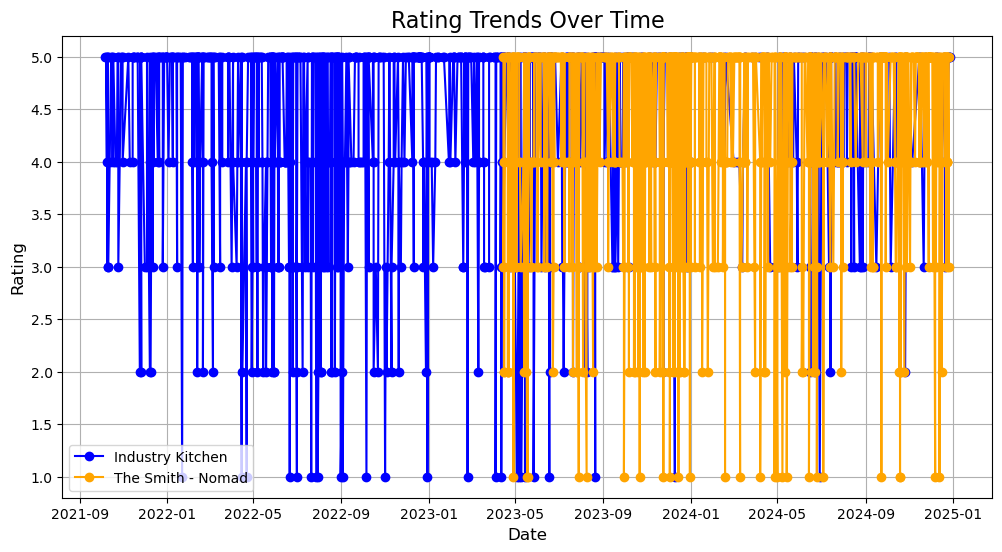

In [3]:
# Task 4

from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import re
import time


def parse_review_date(date_text):
    try:
        # Format: "Dined on December 21, 2024"
        match_full_date = re.search(r"Dined on (\w+ \d{1,2}, \d{4})", date_text)
        if match_full_date:
            return datetime.strptime(match_full_date.group(1), "%B %d, %Y")
        
        # Format: "Dined 3 days ago"
        match_relative_date = re.search(r"Dined (\d+) days ago", date_text)
        if match_relative_date:
            days_ago = int(match_relative_date.group(1))
            return datetime.now() - timedelta(days=days_ago)
    except Exception as e:
        print(f"Error parsing date: {e}")

    return None


def scrape_ratings_by_date(url, max_pages=150):
    browser = webdriver.Chrome()
    browser.get(url)
    WebDriverWait(browser, 10).until(EC.presence_of_element_located((By.TAG_NAME, "h1")))
    
    ratings_data = []
    current_page = 1

    while current_page <= max_pages:
        # Wait until reviews are loaded
        WebDriverWait(browser, 10).until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "li[data-test='reviews-list-item']")))

        # Get the current page source and parse it
        html = browser.page_source
        parsed_html = BeautifulSoup(html, "html.parser")

        # Extract review elements
        review_items = parsed_html.find_all("li", {"data-test": "reviews-list-item"})

        for item in review_items:
            # Extract review date and rating
            date_tag = item.find("p", class_="iLkEeQbexGs-")
            rating_tag = item.find("div", class_="yEKDnyk-7-g-")
            
            try:
                # Parse review date
                review_date = parse_review_date(date_tag.text.strip()) if date_tag else None
                # Parse rating (count stars)
                rating = len(rating_tag.find_all("i", {"data-testid": "star-full"})) if rating_tag else None

                if review_date and rating:
                    ratings_data.append({"date": review_date, "rating": rating})
            except Exception as e:
                print(f"Error processing review: {e}")

        print(f"Page {current_page}: Collected {len(review_items)} reviews.")

        # Check if we've reached the max number of pages
        if current_page >= max_pages:
            break

        # Click the 'Next' button
        try:
            next_page_button = WebDriverWait(browser, 10).until(
                EC.element_to_be_clickable((By.CSS_SELECTOR, "div[data-test='pagination-next']"))
            )
            next_page_button.click()
            current_page += 1
            time.sleep(3)  # Wait for the new page to load
        except Exception as e:
            print(f"Error while navigating to next page: {e}")
            break

    browser.quit()
    return ratings_data


def plot_rating_trends(industry_data, smith_data):
    industry_dates = [entry["date"] for entry in industry_data]
    industry_ratings = [entry["rating"] for entry in industry_data]

    smith_dates = [entry["date"] for entry in smith_data]
    smith_ratings = [entry["rating"] for entry in smith_data]

    plt.figure(figsize=(12, 6))
    plt.plot(industry_dates, industry_ratings, label="Industry Kitchen", marker='o', color='blue')
    plt.plot(smith_dates, smith_ratings, label="The Smith - Nomad", marker='o', color='orange')

    plt.title("Rating Trends Over Time", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Rating", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()


# Scrape data for both restaurants
industry_url = "https://www.opentable.com/r/industry-kitchen-new-york?corrid=8378d68a-8db0-4407-b1c0-81768e053596&avt=eyJ2IjoyLCJtIjoxLCJwIjowLCJzIjowLCJuIjowfQ&p=2&sd=2024-12-01T19%3A00%3A00"
smith_url = "https://www.opentable.com/r/the-smith-nomad-new-york?originId=29cfdf1a-bc62-45d1-b79b-4736b2cf70db&corrid=29cfdf1a-bc62-45d1-b79b-4736b2cf70db&avt=eyJ2IjoyLCJtIjoxLCJwIjowLCJzIjowLCJuIjowfQ"

print("Scraping Industry Kitchen reviews...")
industry_reviews = scrape_ratings_by_date(industry_url, max_pages=90)

print("Scraping The Smith - Nomad reviews...")
smith_reviews = scrape_ratings_by_date(smith_url, max_pages=90)

# Plot the rating trends
plot_rating_trends(industry_reviews, smith_reviews)
